'''
# RK45_Orbit_Simulation
Simulates a comet around the sun. Is adaptable for any gravitational body.

## Replayability
* Input any starting velocity or position
* Change the gravitational field

## Verified with Comet Halley
Within the margin of error of the inputs, it does agree with observation:
* For period (70 vs 74 years)
* Aphelion - furthest distance from Sun - (33.4 vs 35.2 AU)

Note: System highly sensitive to initial conditions, example with 1% higher velocity in plot 

## First Code
First time I publish or code anything that works! \
Did not find a proper orbit simulator that uses the RK45 (Runge-Kutta-Fehlberg) method online. \
I hope it may help someone!

## Improvements
Feel free to build on my code, reference it and keep it free!
* Making animations would be nice! Note that the time steps are variable
* Make it 3D
* Add more bodies and interactions between bodies
'''

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import matplotlib.animation as manimation
import time


@njit
def two_body_ode(position, mu):
    # Mu is equivalent to G (gravity constant) * M (mass of heavier body - Star/Planet)
    r = np.sqrt(position[0] ** 2 + position[1] ** 2)
    a_x = - mu * position[0] / r ** 3
    a_y = - mu * position[1] / r ** 3
    return np.array([a_x, a_y])

@njit
def rk45_step(t, pos_i, vel_i, h, epsi, h_max, h_min, mu):
    
    # Coeficients from Hairer, Norsett & Wanner 1993
 
    # Coeffients for each k
    B21 =   2.500000000000000e-01  #  1/4
    B31 =   9.375000000000000e-02  #  3/32
    B32 =   2.812500000000000e-01  #  9/32
    B41 =   8.793809740555303e-01  #  1932/2197
    B42 =  -3.277196176604461e+00  # -7200/2197
    B43 =   3.320892125625853e+00  #  7296/2197
    B51 =   2.032407407407407e+00  #  439/216
    B52 =  -8.000000000000000e+00  # -8
    B53 =   7.173489278752436e+00  #  3680/513
    B54 =  -2.058966861598441e-01  # -845/4104
    B61 =  -2.962962962962963e-01  # -8/27
    B62 =   2.000000000000000e+00  #  2
    B63 =  -1.381676413255361e+00  # -3544/2565
    B64 =   4.529727095516569e-01  #  1859/4104
    B65 =  -2.750000000000000e-01  # -11/40

# Coefficients for the Truncation error (of the taylor expansion)
    CT1  =   2.777777777777778e-03  #  1/360
    CT2  =   0.000000000000000e+00  #  0
    CT3  =  -2.994152046783626e-02  # -128/4275
    CT4  =  -2.919989367357789e-02  # -2197/75240
    CT5  =   2.000000000000000e-02  #  1/50
    CT6  =   3.636363636363636e-02  #  2/55

# Coefficients for the weighted average (4th order)
# 4th order is used as it is the order to which the error is calculated (Note CH6 is 0)
    CH1  =   1.157407407407407e-01  #  25/216
    CH2  =   0.000000000000000e+00  #  0
    CH3  =   5.489278752436647e-01  #  1408/2565
    CH4  =   5.353313840155945e-01  #  2197/4104
    CH5  =  -2.000000000000000e-01  # -1/5
    CH6  =   0.000000000000000e+00  #  0

    
    TE_step = epsi + 1
    while TE_step > epsi:
        if h > h_max:  # Applying a upward limit as to have enough points on less error prone areas
            h = h_max
            
        elif h < h_min:  # Lower limit to preserve computing power
            h = h_min

        k1 = two_body_ode(pos_i, mu)      # k1 represents the first estimate for the derivative of the Gravitational potential
                                          # In this case this derivative is the estimate for the acceleration
        pos_k2 = pos_i + vel_i * B21 * h  # Computing position that will be used to find instantenous acceleration for k2
        k2 = two_body_ode(pos_k2, mu)
        vel_k2 = vel_i + k1 * B21 * h

        pos_k3 = pos_i + vel_i * B31 * h + vel_k2 * B32 * h
        k3 = two_body_ode(pos_k3, mu)
        vel_k3 = vel_i + k1 * B31 * h + k2 * B32 * h    

        pos_k4 = pos_i + vel_i * B41 * h + vel_k2 * B42 * h + vel_k3 * B43 * h
        k4 = two_body_ode(pos_k4, mu)
        vel_k4 = vel_i + k1 * B41 * h + k2 * B42 * h + k3 * B43 * h

        pos_k5 = pos_i + vel_i * B51 * h + vel_k2 * B52 * h + vel_k3 * B53 * h + vel_k4 * B54 * h
        k5 = two_body_ode(pos_k5, mu)
        vel_k5 = vel_i + k1 * B51 * h + k2 * B52 * h + k3 * B53 * h + k4 * B54 * h

        pos_k6 = pos_i + vel_i * B61 * h + vel_k2 * B62 * h + vel_k3 * B63 * h + vel_k4 * B64 * h + vel_k5 * B65 * h
        k6 = two_body_ode(pos_k6, mu)
        vel_k6 = vel_i + k1 * B61 * h + k2 * B62 * h + k3 * B63 * h + k4 * B64 * h + k5 * B65 * h

        a = CH1 * k1 + CH2 * k2 + CH3 * k3 + CH4 * k4 + CH5 * k5 + CH6 * k6  # Estimate is just the weighted average
        
        TE_step = np.abs(CT1 * k1 + CT2 * k2 + CT3 * k3 + CT4 * k4 + CT5 * k5 + CT6 * k6)
        TE_step = np.max(TE_step)  # Error is always the maximum error
        if TE_step == 0:  # If error is zero, accept the estimate
            t = t + h
            return TE_step, t, a, h          
        if h >= h_max or h <= h_min:
            t = t + h
            return TE_step, t, a, h       
        h = 0.9 * h * (epsi / TE_step) ** (1/5)
        h = np.min(np.array(h))        
        if h > h_max:
            h = h_max 
        elif h < h_min:
            h = h_min
        else:
            t = t + h
            return TE_step, t, a, h # just to break the loop        
    t = t + h
    return TE_step, t, a, h


def main(pos_i, vel_i, t, t_f, h, epsilon, h_maximum, h_minimum, mu, name_comet = 'comet'):
    
    pos_x = []
    pos_y = []
    h_array = []
    speed_array = []
    error_array = []
    time_array = []
    while t < t_f:
        error, t, a_, h = rk45_step(t, pos_i, vel_i, h, epsilon, h_maximum, h_minimum, mu)
        vel_i = vel_i + a_ * h
        pos_i = pos_i + vel_i * h
        error_array = np.append(error_array, error)
        pos_x = np.append(pos_x, pos_i[0])
        pos_y = np.append(pos_y, pos_i[1])
        speed = np.sqrt(vel_i[1] ** 2 + vel_i[1] ** 2)
        speed_array = np.append(speed_array, speed)
        time_array = np.append(time_array, t)
        h_array.append(h)
    print('Number of Points', len(pos_x))
    ax = plt.gca()
    ax.set_facecolor("lavender")
    plt.plot(np.sqrt(pos_x ** 2 + pos_y ** 2), h_array, '.', markersize = 3)
    plt.title('Evolution of step size in relation to distance to sun')
    plt.xlabel('Distance to sun (AU)')
    plt.ylabel('Step size (h)')
    plt.grid(True)
    plt.show()
    ax = plt.gca()
    ax.set_facecolor("lavender")
    plt.plot(time_array, h_array, '.', markersize = 3 )
    plt.title('Evolution of step size in relation to time')
    plt.xlabel('Time (Years)')
    plt.ylabel('Step size (h)')
    plt.grid(True)
    plt.show()
    ax = plt.gca()
    ax.set_facecolor("lavender")
    plt.plot(time_array, speed_array, '.', markersize = 3)
    plt.title('Evolution of speed')
    plt.ylabel('Speed in AU / Year')
    plt.xlabel('Time (Years)')
    plt.grid(True)
    plt.show()
    ax = plt.gca()
    ax.set_facecolor("lavender")
    plt.plot(time_array, error_array, '.', markersize = 3)
    plt.title('Evolution of error')
    plt.xlabel('Time (Years)')
    plt.ylabel('Error')
    plt.grid(True)
    plt.show()
    ax = plt.gca()
    ax.set_facecolor("lavender")
    plt.plot(pos_x, pos_y,'.', markersize = 1 )
    plt.plot(0,0,'.', markersize =3)
    plt.annotate('SUN', xy =(0 ,0) , ha='center', va='center', bbox = dict ( boxstyle =" circle ", fc ="darkorange") )
    plt.title('Plot of %s orbit in Au' %name_comet)
    plt.xlabel('x (AU)')
    plt.ylabel('y (AU)')
    plt.grid(True)
    plt.axis('scaled')
    plt.show()
    print('Maximum distance prom sun (Aphelion)', np.min(pos_x))
    

# Halley Comet: Verifying the Model

Halley was only 0.5871 AU (87.8 million km: 54.6 million miles) from the Sun, well inside the orbit of Venus. 

Halley was moving at 122,000 mph (54.55 kilometers per second) Nasa, 2020

Experimental data:
* Orbital period (sidereal)	74.7 yr
* 75y 5m 19d (perihelion to perihelion)

In [4]:
# Units: AU and years
v_halley = 122000 / 10611.393524 # miles/h to AU/year
print(v_halley, ':  AU per Year')
px_halley =  0.5871
# G*M for the sun
GM = 1.32712440042e20  #m3s-2
GM *= 31_556_952 ** 2  # second to year squared
GM /= 149597870691 ** 3 
print(GM, ':  AU ** 3 * y ** -2')

11.497076206256057 :  AU per Year
39.47530521614961 :  AU ** 3 * y ** -2


## Plot 1
For a small epsilon/error

Number of Points 20878


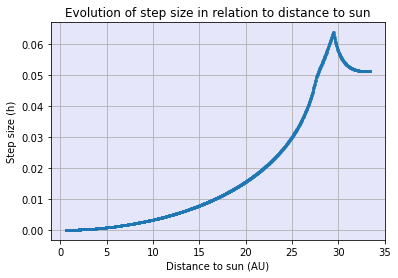

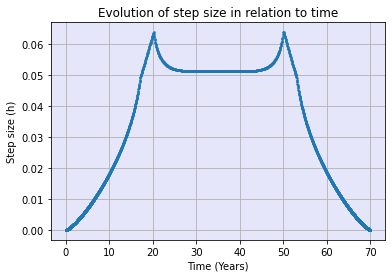

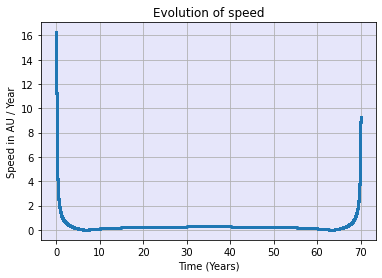

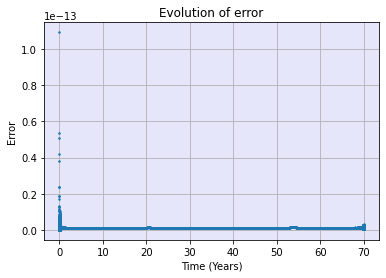

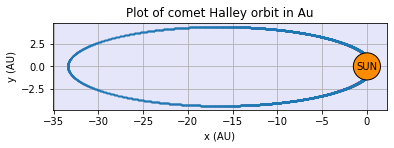

Maximum distance prom sun (Aphelion) -33.41842350549968
1.8290724754333496 seconds processing time


In [6]:
pos_initial = np.array([px_halley, 0])
vel_initial = np.array([0,v_halley])
t_ = 0
t_final = 70
epsilon_ = 2.2e-15
h_maximum_ = 10
h_minimum_ = 5e-14
h_ = 10 * h_minimum_
t0_proc = time.time()    
main(pos_initial, vel_initial, t_, t_final, h_, epsilon_, h_maximum_, h_minimum_, GM, 'comet Halley')
print(time.time() - t0_proc, "seconds processing time")

## Plot 2
With a 0.5% error in Velocity and Position

Number of Points 28093


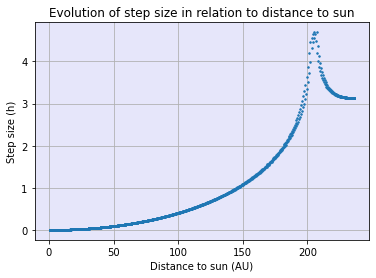

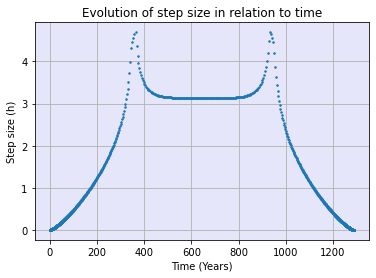

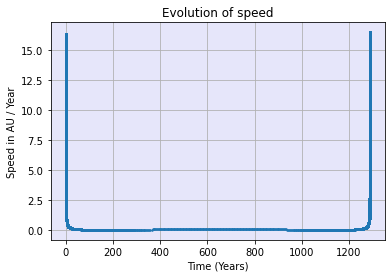

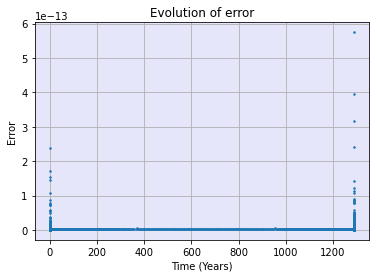

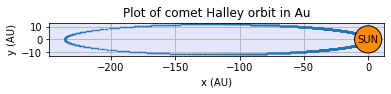

Maximum distance prom sun (Aphelion) -236.14831425719925
1.9338006973266602 seconds process time


In [9]:
pos_initial = np.array([px_halley * 1.005, 0])
vel_initial = np.array([0, v_halley * 1.005])
t_ = 0
t_final = 1290
epsilon_ = 5e-15
h_maximum_ = 100
h_minimum_ = 1e-7
h_ = 10 * h_minimum_
t0_proc = time.time()    
main(pos_initial, vel_initial, t_, t_final, h_, epsilon_, h_maximum_, h_minimum_, GM, 'comet Halley')
print(time.time() - t0_proc, "seconds process time")

# Very long Periods

## Plot 3
500 years later...

Note: RK45 does not conserve energy

131744


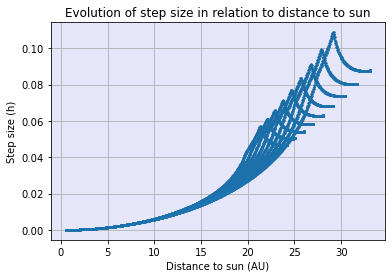

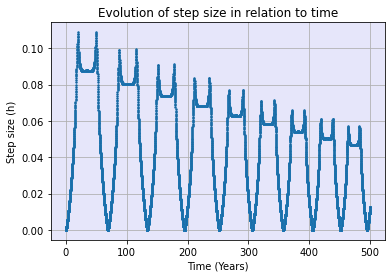

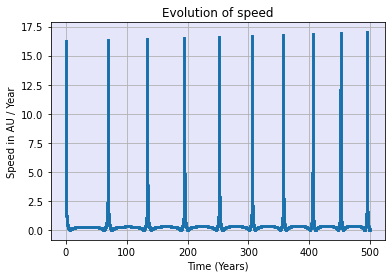

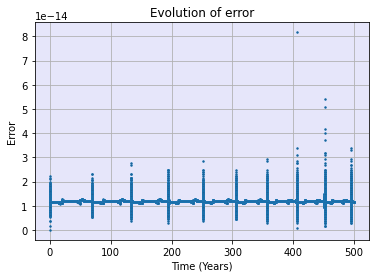

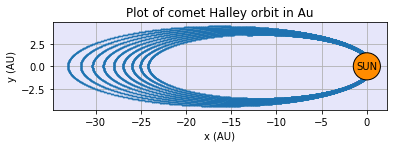

-33.09723397868688
21.14301824569702 seconds process time


In [ ]:
pos_initial = np.array([px_halley, 0])
vel_initial = np.array([0,v_halley])
t_ = 0
t_final = 500
epsilon_ = 2e-14
h_maximum_ = 10
h_minimum_ = 1e-7
h_ = 10 * h_minimum_
t0_proc = time.time()    
main(pos_initial, vel_initial, t_, t_final, h_, epsilon_, h_maximum_, h_minimum_, GM, 'comet Halley')
print(time.time() - t0_proc, "seconds process time")

## Plot 4
1000 years later...

Look at this crazy process time

366717


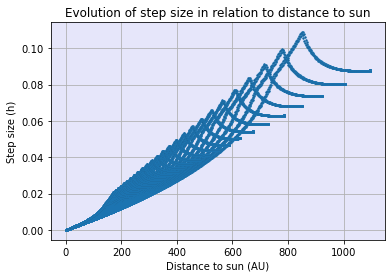

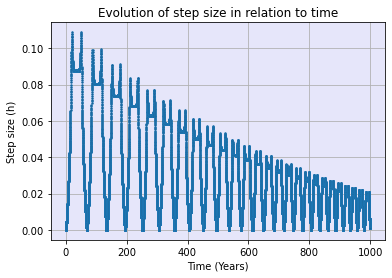

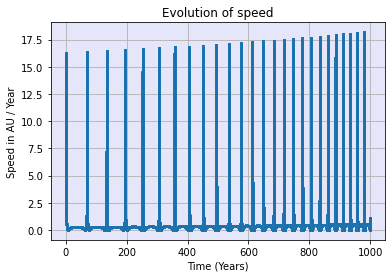

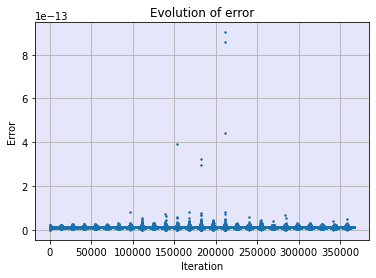

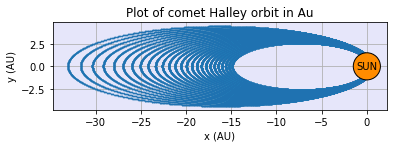

537.7314183712006 seconds process time


In [ ]:
pos_initial = np.array([px_halley, 0])
vel_initial = np.array([0,v_halley])
t_ = 0
t_final = 1000
epsilon_ = 2e-14
h_maximum_ = 10
h_minimum_ = 1e-7
h_ = 10 * h_minimum_
t0_proc = time.time()    
main(pos_initial, vel_initial, t_, t_final, h_, epsilon_, h_maximum_, h_minimum_, GM, 'comet Halley')
print(time.time() - t0_proc, "seconds process time")

# Testing using initial conditions at Aphelion
At aphelion in 1948, Halley was 35.25 AU (3.28 billion miles or 5.27 billion kilometers) from the Sun.

Well beyond the distance of Neptune. The comet was moving 0.91 kilometers per second (2,000 mph). 

In [ ]:
# Units: AU and years
v_halley2 = 2035.612 / 10611.393524 # miles/h to AU/year
print(v_halley2, ':  AU per Year')
px_halley2 =  35.25
# G*M for the sun
GM = 1.32712440042e20  #m3s-2
GM *= 31_556_952 ** 2  # second to year squared
GM /= 149597870691 ** 3 
print(GM, ':  AU ** 3 * y ** -2')

0.19183267451122382 :  AU per Year
39.47530521614961 :  AU ** 3 * y ** -2


## Plot 5
Same period of 70 years \
Source: Wikipedia - maybe - that is possibly the reason for worse performance \
Note: Highly sensible to initial conditions

13648


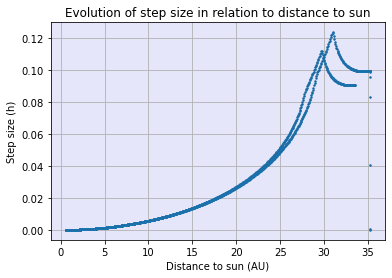

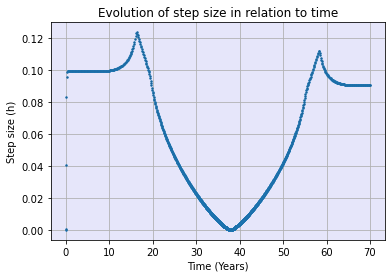

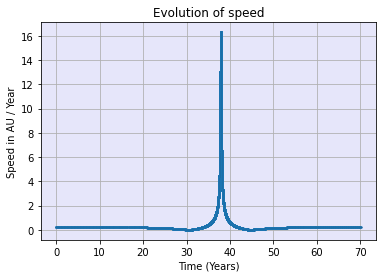

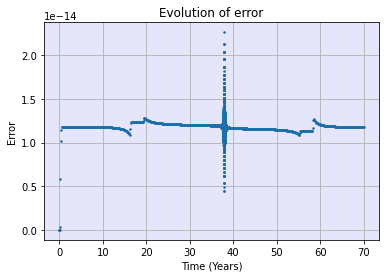

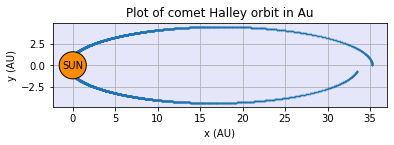

-0.5853738498659607
0.9814493656158447 seconds process time


In [ ]:
pos_initial = np.array([px_halley2, 0])
vel_initial = np.array([0,v_halley2])
t_ = 0
t_final = 70
epsilon_ = 2e-14
h_maximum_ = 10
h_minimum_ = 1e-8
h_ = 10 * h_minimum_
t0_proc = time.time()    
main(pos_initial, vel_initial, t_, t_final, h_, epsilon_, h_maximum_, h_minimum_, GM, 'comet Halley')
print(time.time() - t0_proc, "seconds process time")

5264


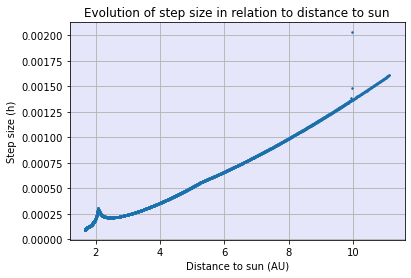

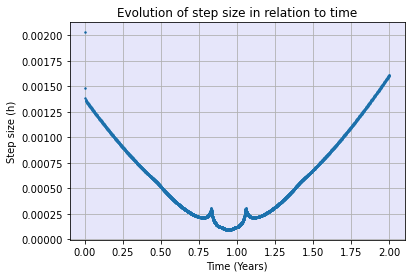

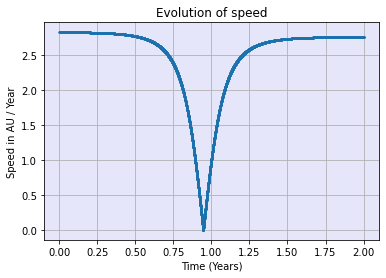

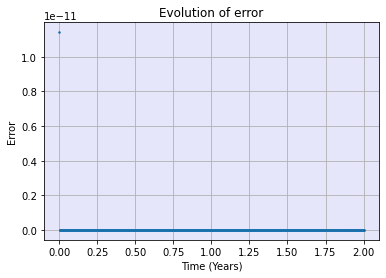

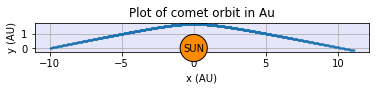

-9.97968713536337
2.704371690750122 seconds process time


In [ ]:
G_M = 39.5 
pos_initial = np.array([-10, 0])
vel_initial = np.array([10, 2])
t_ = 0
t_final = 2
h_ = 0.01
epsilon_ = 6.685e-15
h_maximum_ = 0.11
h_minimum_ = 1e-15
t0_proc = time.time()    
main(pos_initial, vel_initial, t_, t_final, h_, epsilon_, h_maximum_, h_minimum_, G_M)
print(time.time() - t0_proc, "seconds process time")

36593


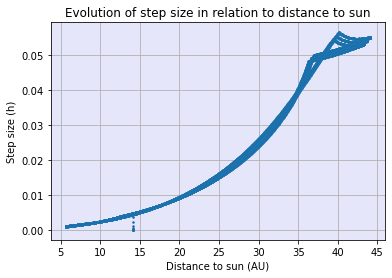

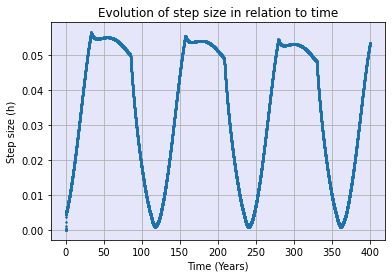

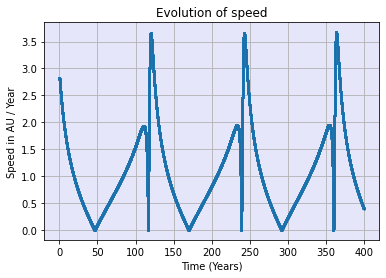

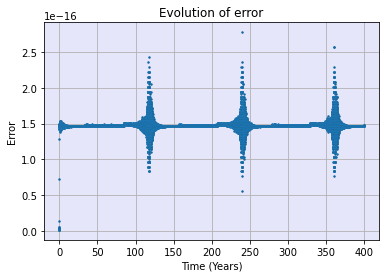

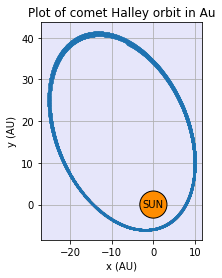

-25.206515795313344
2.590264320373535 seconds process time


In [ ]:
pos_initial = np.array([10, 10])
vel_initial = np.array([0, 2])
t_ = 0
t_final = 400
epsilon_ = 2.5e-16
h_maximum_ = 10
h_minimum_ = 1e-7
h_ = 10 * h_minimum_
t0_proc = time.time()    
main(pos_initial, vel_initial, t_, t_final, h_, epsilon_, h_maximum_, h_minimum_, GM, 'comet Halley')
print(time.time() - t0_proc, "seconds process time")